Ce carnet renseigne les différents traitements mis en oeuvre pour une pige publiée sur Rue89 Strasbourg. Un des principaux objectifs était **d'analyser les chiffres de mortalité sur une zone précise** (les départements alsaciens) **en utilisant des moyennes et des segmentations par âge**. 

Il s'agissait (ô surprise) **de comparer les chiffres de la mortalité en 2020 avec les années précédentes** sur la même période.

Le réservoir de données privilégié est [le fichier des personnes décédées](https://www.data.gouv.fr/fr/datasets/fichier-des-personnes-decedees/) fourni par l'INSEE sur le portail data.gouv.fr. J'ai téléchargé :
* les **fichiers annuels** deces-2019.txt, deces-2018.txt, etc jusqu'à deces-2010.txt inclus
* les **fichiers mensuels** deces-2020-m03.txt et deces-2020-m04.txt

**Un article "pas à pas"**, avec des allers retours et des descriptions d'erreurs, **aurait été très vite ennuyeux**. Je vais plutôt factoriser ce que j'avais déjà fait dans un autre carnet, en espérant que le résultat soit à la hauteur.

## Premières fonctions sur le fichier de 2019

Commençons par manipuler **le fichier deces-2019.txt**. Cela permettra de faire quelques rappels sur des fonctions parmi les plus simples et les plus usuelles [du module Python couteau-suisse-data fort bien nommé... pandas](https://pandas.pydata.org/).


In [1]:
import pandas as pd

La fonction pandas de base pour les fichiers txt est **read_csv()**. Elle permet de transformer des fichiers csv (mais pas que, donc) en DataFrames. En gros, un format de données **à la structure proche d'un tableur Excel**, sur lequel on peut ensuite appliquer de nombreuses fonctions.

Les fichiers fournis pas l'INSEE **nécessitent quelques transformations** avant de pouvoir les exploiter comme ils le méritent.

Codons une première fonction qui ouvre un fichier et le transforme en DF ultra basique : une colonne "brut", et des lignes de texte qui s'enchaînent :

In [2]:
def ouverture_facile(periode):
    # on a ajoute un encodage, sans quoi la fonction butera sur certains fichiers
    DF = pd.read_csv("deces-"+periode+".txt", header = None, names=(['brut']), encoding = "ISO-8859-1")
    return DF

L'argument de la fonction étant **une année ou un mois type 2020-m03**, on va ouvrir le fichier de 2019 sans s'énerver :

In [3]:
deces_2019 = ouverture_facile("2019")  # très important : chaîne de cara en argument, pas de chiffre

deces_2019.tail() # rappel : tail() affiche les cinq dernières lignes d'une DF

,brut
625367,LEVEQUE*EMILIENNE MARIE ANNE/ ...
625368,VIAL*MAXIME THEODORE LUCAS/ ...
625369,BOUTEMY*XAVIER STEPHANE PAUL CHRISTIAN/ ...
625370,FERAHTIA*KAMEL/ ...
625371,TARCHINI*MICHELINE JEANNE/ ...


**Une base de données de plus de 625 000 occurrences**, que demande le peuple ? **Peut-être des colonnes dignes de ce nom**.

Pour cela, on va "trancher" ([ou slicer](https://docs.python.org/3/c-api/slice.html)) chaque ligne de la DataFrame précédente pour ne retenir que les infos dignes d'intérêt, qu'on répartira dans les différentes colonnes.

Une des principales qualités de pandas est de raisonner "en gros", **sans avoir recours aux itérations**. La future fonction va :
* prendre **une DF pas hyper propre** en argument 
* calquer **une nouvelle DF** sur cette dernière
* isoler un maximum de **"tranches" intéressantes dans des colonnes dédiées**

Il va falloir être vigilant et ne pas utiliser directement la notation de tranchage sur la DF (par exemple DF[:2]). Cela permet de sélectionner des lignes d'une DF, mais pas de manipuler des colonnes de chaînes de caractères. Heureusement, la fonction [str.slice()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.slice.html) est là.

C'est parti ? C'est parti :

In [4]:
def DF_propre(DF_sale):
    # on va lister les différents index de deces19_fr
    # ainsi, la DF tampon aura exactement le même nombre de lignes
    l_index = DF_sale.index.tolist()

    # place à la belle coquille vide
    tampon = pd.DataFrame(index=l_index, columns=['naissance','deces','age','dep_deces', 'd_deces', 'n_acte_deces'])
    
    # à présent, on découpe    
    tampon['naissance'] = DF_sale['brut'].str.slice(start = 81, stop = 89)
    tampon['d_deces'] = DF_sale['brut'].str.slice(start = 154, stop = 162)
    tampon['dep_deces'] = DF_sale['brut'].str.slice(start = 162, stop = 164)
    tampon['n_acte_deces'] = DF_sale['brut'].str.slice(start = 167, stop = 175)
    
    # et on sert    
    return tampon

On teste :

In [5]:
deces_2019 = DF_propre(deces_2019)

deces_2019.tail()

,naissance,deces,age,dep_deces,d_deces,n_acte_deces
625367,19250928,NaN,NaN,99,20180301,3662
625368,20190103,NaN,NaN,99,20190722,3787
625369,19670224,NaN,NaN,99,20191016,3799
625370,19730521,NaN,NaN,99,20141022,4802
625371,19310919,NaN,NaN,99,20190929,1299


On a bien nos différentes colonnes, la BDD contient toujours le bon nombre de lignes. C'est propre !

Cela dit, **il y a beaucoup de colonnes dont on ne va pas se servir** dans cette partie. Autant ne garder que le nécessaire :

In [6]:
deces_2019 = deces_2019[["dep_deces","d_deces", "n_acte_deces"]]

deces_2019.tail()

,dep_deces,d_deces,n_acte_deces
625367,99,20180301,3662
625368,99,20190722,3787
625369,99,20191016,3799
625370,99,20141022,4802
625371,99,20190929,1299


Qu'est-ce qu'on peut encore faire, à ce stade ? Les plus observateurs auront sans doute remarqué l'avant-dernière date de décès **qui remonte à octobre... 2014**. Cela arrive assez souvent dans les fichiers de l'INSEE, notamment pour les décès survenus à l'étranger.

**On va gommer ces bizarreries** en paramétrant une nouvelle fonction qui prendra en argument une année (toujours en chaîne de caractères) : 

In [7]:
def annee_stricte(DF, annee):
    # le plus simple est de déclarer une condition en variable, par exemple...
    bonne_annee = DF["d_deces"].str.slice(start = 0, stop = 4) == annee
    # puis de s'en servir pour purger DF
    DF = DF[bonne_annee]
    return DF

Plus qu'à tester :

In [8]:
deces_2019 = annee_stricte(deces_2019,"2019")

deces_2019.info()   # info() va nous donner l'armature de la DF

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602096 entries, 0 to 625371
Data columns (total 3 columns):
dep_deces       602096 non-null object
d_deces         602096 non-null object
n_acte_deces    602096 non-null object
dtypes: object(3)
memory usage: 18.4+ MB


Tout de même 20 000 décès effacés dans la manip. La tentation est grande de tout de même vérifier qu'on ne trouve que 2019 (on n'a jamais tort de vérifier). 

La fonction pandas [unique()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html) est parfaite pour ça :

In [9]:
# on va vérifier les différentes valeurs uniques des quatre premiers caractères de d_deces
# ...si on a tout fait bien, ce devrait être '2019', y nada mas

print(deces_2019["d_deces"].str.slice(start = 0, stop = 4).unique())

['2019']


Qué bien ! Nous pouvons encore affiner la sélection **en la limitant (par exemple) à un département**. 

Le principe est similaire à la fonction précédente, mais en se concentrant sur le seul contenu de la Serie **dep_deces** :

In [10]:
def selection_dep(DF, dep):
    # comme d'hab, une condition en variable
    condi_dep = DF["dep_deces"] == dep
    # puis l'écrémage
    DF = DF[condi_dep]
    return DF

On peut cette fois (et pour ne pas s'emmêler les pinceaux trop vite) partir sur **une nouvelle DF centrée sur le Haut-Rhin** :

In [11]:
deces_68_2019 = selection_dep(deces_2019,"68")

deces_68_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6781 entries, 40110 to 607455
Data columns (total 3 columns):
dep_deces       6781 non-null object
d_deces         6781 non-null object
n_acte_deces    6781 non-null object
dtypes: object(3)
memory usage: 211.9+ KB


Propre. Manie de la vérif oblige, une petite ligne de précaution :

In [12]:
print(deces_68_2019["dep_deces"].unique())

['68']


Notre fuite en avant nous amène à un moment charnière : **tailler également la DF sur deux mois** (la période idéale pour ce sujet précis).

Vous entendez le bruit des gros sabots : 

* une DF, un mois de début, et un mois de fin en arguments 
* une condition en variable. Une condition, pas tout à fait. On va plutôt se servir [d'un masque booléen](https://fr.wikipedia.org/wiki/Masquage) pour éviter les erreurs d'indexation
* un écrémage (et surtout, une restitution de cet écrémage)

In [13]:
def bimensuel(DF, m_debut, m_fin):
    # les dates de décès qui nous intéressent sont dans le mois du début ou le mois de fin, ce qui donne...
    masque_periode = ((DF["d_deces"].str.slice(start = 4, stop = 6) == m_debut) | (DF["d_deces"].str.slice(start = 4, stop = 6) == m_fin))
    
    DF = DF.loc[masque_periode]
    
    return DF

Et c'est parti pour cette nouvelle DF, encore plus légère :

In [14]:
deces_68_mav19 = bimensuel(deces_68_2019,"03","04")

deces_68_mav19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1163 entries, 156944 to 554746
Data columns (total 3 columns):
dep_deces       1163 non-null object
d_deces         1163 non-null object
n_acte_deces    1163 non-null object
dtypes: object(3)
memory usage: 36.3+ KB


Bonne nouvelle : cela colle avec [les comptages départementaux](https://www.insee.fr/fr/information/4190491) publiés par l'INSEE. Pas d'erreur, donc !

Cerise sur le gâteau : **on n'est pas obligé de suivre l'ordre précédent** pour obtenir le même résultat avec les fonction bimensuel(), annee_stricte() et selection_dep(). Cela aura évidemment une importance sur la suite des événements !

Pour l'heure, on va additionner les décès survenus un même jour, pour obtenir **les totaux quotidiens sur une période donnée**. 

Parmi les objectifs à garder en tête, il y a celui de **superposer différentes années**, par exemple les décès survenus un 9 avril chaque année depuis 2009. On ne va pas convertir les données de d_deces en dates uniques, mais plutôt la détourner en :

* **virant l'année** (les quatre premiers caractères)
* gardant la notation américaine (moisjour) pour non seulement rassembler les décès mais aussi trier **dans l'ordre croissant ces chaînes de caractères**. Ca va marcher comme sur des roulettes
* affichant la date **dans un format européen propre**, type "jour-mois"

Invoquons [des expressions régulières](https://fr.wikipedia.org/wiki/Expression_r%C3%A9guli%C3%A8re) à la rescousse de cette fonction :

In [15]:
def compteur_quotidien(DF, annee):
    # d'abord, on reformule d_deces en ne gardant que les caractères correspondant au mois et au jour
    DF["d_deces"] = DF["d_deces"].str.replace(r'\d{4}(\d{2})(\d{2})', r'\g<1>-\g<2>')
    
    # ensuite, on ne retient de la DataFrame que la colonne d_deces
    DF = DF[['d_deces']]
    
    # on additionne les décès qui partagent une même date, on les trie et on réindexe la DF
    DF = DF['d_deces'].value_counts().sort_index().reset_index()
    
    # on crée les colonnes associées
    DF.columns = ['d_deces', annee]

    # on reformule les valeurs de d_deces au format européen
    DF['d_deces'] = DF['d_deces'].str.replace(r'(\d{2})-(\d{2})', r'\g<2>-\g<1>')
    
    # c'est prêt
    return DF

C'est parti pour la création et vérification d'une nouvelle DataFrame créée avec cette fonction :

In [16]:
decesq_68_mav19 = compteur_quotidien(deces_68_mav19, "2019")

decesq_68_mav19

<ipython-input-15-80f17c0d05a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF["d_deces"] = DF["d_deces"].str.replace(r'\d{4}(\d{2})(\d{2})', r'\g<1>-\g<2>')


,d_deces,2019
0,01-03,19
1,02-03,22
2,03-03,12
3,04-03,25
4,05-03,19
...,...,...
56,26-04,26
57,27-04,24
58,28-04,23
59,29-04,18


Devinez quoi ? **C'est encore conforme** aux chiffres d'ensemble de l'INSEE.

On est plutôt bien parti. Assez pour passer à la suite.

## Le lissage par la moyenne

La tentation est grande de réitérer ce qui a été fait précédemment. On va pousser le vice jusqu'à écrire une nouvelle fonction pour cela, **qui va nous mâcher le travail** :

In [17]:
def panorama_periode(annee,m_debut,m_fin,dpt):
    DF = ouverture_facile(annee)
    
    DF = DF_propre(DF)
    
    DF = DF[["dep_deces","d_deces", "n_acte_deces"]]
    
    DF = annee_stricte(DF, annee)
    
    DF = selection_dep(DF,dpt)
    print("En ",annee,", ",len(DF['d_deces']), " décès survenus dans le département", dpt,"...")
    
    DF = bimensuel(DF, m_debut, m_fin)
    print("...dont ", len(DF['d_deces'])," entre les mois", m_debut, " et ",m_fin)
    
    DF = compteur_quotidien(DF, annee)
    
    return DF

Propre ? C'est ce que nous allons découvrir :

In [18]:
decesq_68_mav18 = panorama_periode("2018", "03","04","68")

decesq_68_mav18

En  2018 ,  6827  décès survenus dans le département 68 ...
...dont  1243  entre les mois 03  et  04


,d_deces,2018
0,01-03,25
1,02-03,16
2,03-03,21
3,04-03,35
4,05-03,29
...,...,...
56,26-04,14
57,27-04,21
58,28-04,12
59,29-04,21


On va visualier les deux dernières DF créées pour comparer 2019 et 2018 :

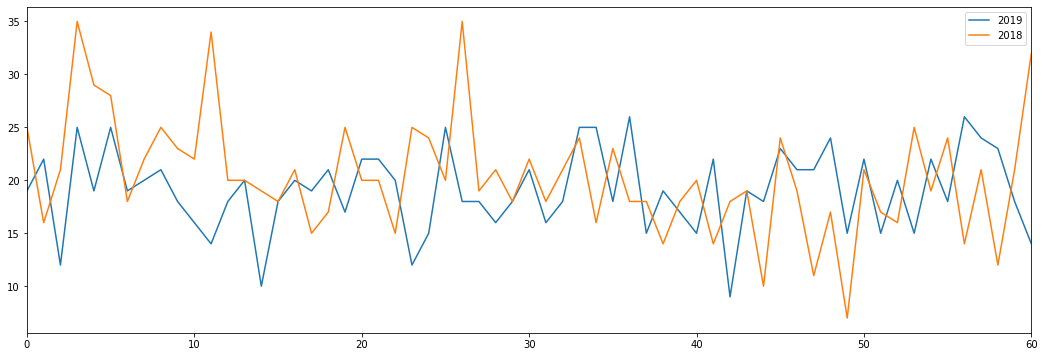

In [19]:
ax = decesq_68_mav19.plot(figsize=(18, 6))
decesq_68_mav18.plot(ax=ax)

Hormis pour quelques dates avec de grands écarts, le graphique n'est pas très lisible. Et cela va sans aucun doute empirer en considérant plus d'années... **La moyenne de l'ensemble des décès survenus un même jour** serait sans doute plus adaptée.

Une solution assez simple à mettre en oeuvre consiste à utiliser **la fonction panorama_periode() dans une itération**. Ce n'est sans doute pas l'option la plus propre mais on va partir sur une nouvelle fonction, qui remplira une DataFrame (contenant juste une plage de dates) au fur et à mesure.

In [20]:
def moyenne_dep_periode(DF_a_remplir, a_debut, a_fin, m_debut, m_fin, dpt):
    # on met dans un tableau l'ensemble des années, de la plus récente à la plus ancienne
    # attention on utilise pour le coup des nombres entiers et pas des chaînes de cara. Sinon range(),ça marche pas
    periode = [str(an) for an in range(a_fin, a_debut, -1)]
    
    # et on déclare une boucle for sur chacune d'entre elles
    for annee in periode:
        DF_transitoire = panorama_periode(annee,m_debut,m_fin,dpt)
        # le résultat du panorama ? on le fusionne avec
        DF_a_remplir = pd.merge(DF_a_remplir, DF_transitoire, on="d_deces", how='left').fillna(0)
    # une fois sortie de la boucle, on calcule la moyenne sur l'ensemble de la période
    DF_a_remplir["moyenne"] = DF_a_remplir[periode].mean(axis=1)
    return DF_a_remplir

Plus qu'à créer la DF avec les dates de références calquées sur une année précédente, à la remplir :

In [21]:
# on va créer une référence des dates qui sera plus claire
mav = pd.DataFrame(columns=["d_deces"])
mav["d_deces"] = decesq_68_mav19["d_deces"]

# on crée ensuite la DF à remplir au fur et à mesure
moyenne_68 = pd.DataFrame(columns=["d_deces"])
moyenne_68["d_deces"] = mav["d_deces"]

# et on la met à jour à partir de la grosse fonction codée précédemment
moyenne_68 = moyenne_dep_periode(moyenne_68, 2009, 2019, "03","04","68")

En  2019 ,  6781  décès survenus dans le département 68 ...
...dont  1163  entre les mois 03  et  04
En  2018 ,  6827  décès survenus dans le département 68 ...
...dont  1243  entre les mois 03  et  04
En  2017 ,  6713  décès survenus dans le département 68 ...
...dont  1056  entre les mois 03  et  04
En  2016 ,  6484  décès survenus dans le département 68 ...
...dont  1095  entre les mois 03  et  04
En  2015 ,  6619  décès survenus dans le département 68 ...
...dont  1157  entre les mois 03  et  04
En  2014 ,  6074  décès survenus dans le département 68 ...
...dont  1103  entre les mois 03  et  04
En  2013 ,  6280  décès survenus dans le département 68 ...
...dont  1139  entre les mois 03  et  04
En  2012 ,  6077  décès survenus dans le département 68 ...
...dont  1078  entre les mois 03  et  04
En  2011 ,  5793  décès survenus dans le département 68 ...
...dont  958  entre les mois 03  et  04
En  2010 ,  5948  décès survenus dans le département 68 ...
...dont  1041  entre les mois 03

Voici venue l'heure de vérité. L'heure de vérifier :

In [22]:
moyenne_68

,d_deces,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,moyenne
0,01-03,19,25,14,16,27,16,21,23,12,17,19.0
1,02-03,22,16,13,21,17,10,21,28,13,20,18.1
2,03-03,12,21,17,20,22,20,18,27,18,24,19.9
3,04-03,25,35,19,26,13,11,26,20,21,16,21.2
4,05-03,19,29,23,22,31,20,28,20,25,17,23.4
...,...,...,...,...,...,...,...,...,...,...,...,...
56,26-04,26,14,25,18,14,15,15,22,10,17,17.6
57,27-04,24,21,16,17,13,19,11,17,15,20,17.3
58,28-04,23,12,22,23,23,16,13,19,14,15,18.0
59,29-04,18,21,20,14,18,14,14,14,10,15,15.8


A présent, visualisons ces différentes périodes :

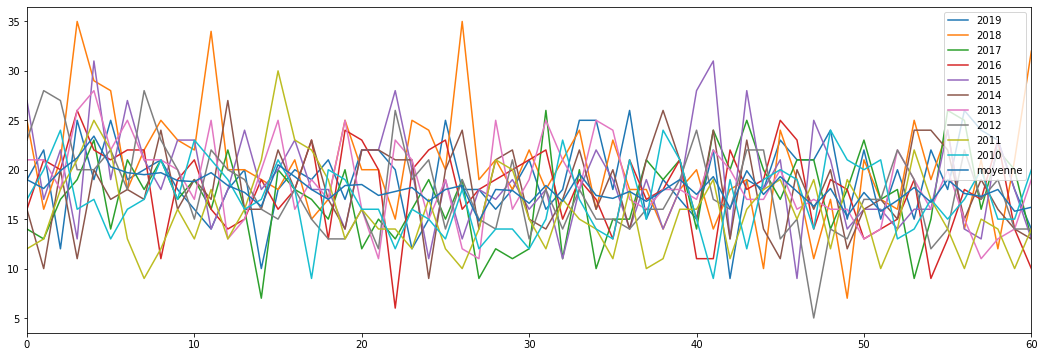

In [23]:
moyenne_68.plot(figsize=(18, 6))

**Grande nouvelle : c'est illisible...** En plissant les yeux, on distingue malgré tout **l'effet de lissage** de la moyenne. On va donc la retenir pour résumer les décès quotidiens pendant cette décennie.

Mais avant, et en prévision d'une future infographie, on va aussi conserver l'ensemble des années comme un "bruit de fond", un décor qui montrera concrètement le lissage de la moyenne :

In [24]:
bruit_mav_68 = moyenne_68.drop(columns=['moyenne'])

Ces infos mémorisées, on ne retient de moyenne_68 que la colonne 'moyenne' :

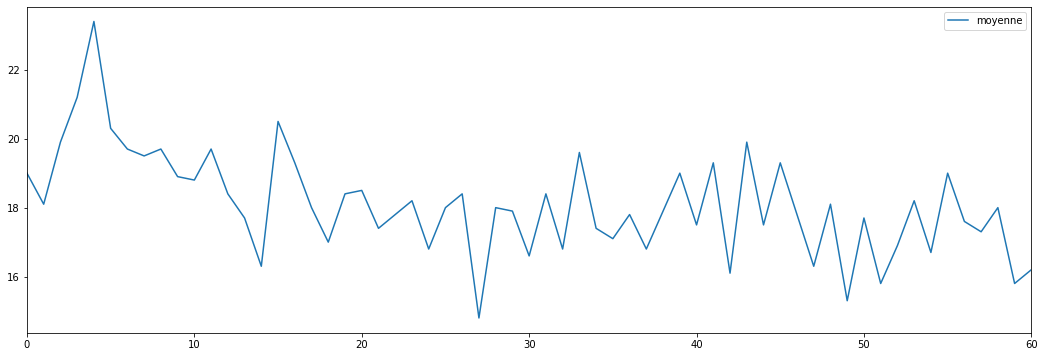

In [25]:
moyenne_68 = moyenne_68[['d_deces','moyenne']]
moyenne_68.plot(figsize=(18, 6))

Désormais, la suite des opérations va consister à **compiler les chiffres de 2020 sur la même période**, afin de les comparer à cette moyenne !

## Fusion brute et jointures

L'INSEE a pris l'initiative de publier **des fichiers de décès mensuels et trimestriels des décès de 2020**. Leur structure est la même que les listings annuels, en revanche ils nécessitent quelques aménagements.

On va déjà coder une fonction qui fusionne de façon propre deux fichiers mensuels :

In [26]:
def fusion_propre(fichier1,fichier2):
    DF1 = ouverture_facile(fichier1)
    print(len(DF1['brut']), " lignes dans le premier fichier")
    
    DF2 = ouverture_facile(fichier2)
    print(len(DF2['brut']), " lignes dans le second fichier")
    
    # pandas intégère dans son panel de fonction append(), calqué sur le modèle des listes
    DF = DF1.append(DF2, ignore_index = True)
    print (len(DF['brut']), " lignes dans le fichier final")
    
    return DF

Un petit test pour la route ?

In [27]:
test_fusion = fusion_propre("2020-m03","2020-m04") # attention au nom de période

57269  lignes dans le premier fichier
70943  lignes dans le second fichier
128212  lignes dans le fichier final


L'occasion est idéale pour coder une nouvelle fonction, largement inspirée de panorama_periode() :

In [28]:
def panorama_periode_2020(fichier1, fichier2,m_debut,m_fin,dpt):
    annee = "2020" # indispensable, sans quoi ça plantera
    
    DF = fusion_propre(fichier1, fichier2)    
    DF = DF_propre(DF)
    
    DF = DF[["dep_deces","d_deces", "n_acte_deces"]]
    
    DF = annee_stricte(DF, annee)
    #print(len(DF['d_deces']), " décès notés sur les mois", m_debut, " et ",m_fin)
    
    DF = selection_dep(DF,dpt)
    print("En ",annee,", ",len(DF['d_deces']), " décès survenus dans le département", dpt,"...")
    
    DF = bimensuel(DF, m_debut, m_fin)
    print("...dont ", len(DF['d_deces'])," entre les mois", m_debut, " et ",m_fin)
    
    DF = compteur_quotidien(DF, annee)
    
    return DF

Et de la tester illico :

In [29]:
decesq_68_mav20 = panorama_periode_2020("2020-m03", "2020-m04", "03", "04", "68")

decesq_68_mav20.tail()

57269  lignes dans le premier fichier
70943  lignes dans le second fichier
128212  lignes dans le fichier final
En  2020 ,  2437  décès survenus dans le département 68 ...
...dont  2347  entre les mois 03  et  04


,d_deces,2020
55,25-04,10
56,26-04,6
57,27-04,11
58,28-04,3
59,29-04,1


Deux remarques, la première anecdotique, la seconde importante :

* il manque la ligne du 30 avril, qu'on va devoir gommer sur moyenne_68 pour avoir deux DF de la même taille
* en inspectant l'ensemble des chiffres, des différences sont constatés avec les fichiers départementaux de l'INSEE. Cela peut venir **de décès pas encore comptabilisés** dans le fichier quotidien (il y avait parfois une à deux unités en plus dans le fichier départemental), **ou de rattrapages** (il y avait parfois quatre à cinq unités de plus dans la DF créée par nos soins). L'INSEE précise bien que les données du fichier départemental sont *provisoires, révisées chaque jour et susceptibles d'évoluer fortement les derniers jours*

Ce qu'il faut retenir, c'est que les **fonctions codées avant sont justes**, sélectionnent correctement les mois et le département de décès et additionnent les décès survenus à même jour. 

Rappelons aussi que produire des données est coûteux et rugueux, qu'elles ont leurs limites mais que ça ne pose aucun problème si on en a conscience. D'où l'intérêt de cette méthodo !

Revenons à nos moutons, en préparant la DF de comparaison :

In [30]:
mav20_vs_moyenne_68 = moyenne_68.iloc[:-1]

# les deux DF ayant la même taille, on les fusionne en servant de d_deces comme id de jointure

mav20_vs_moyenne_68 = pd.merge(mav20_vs_moyenne_68, decesq_68_mav20, on="d_deces", how='left').fillna(0)

# et on vire les lignes à partir desquels l'écart des décès cumulés devient trop élevé

mav20_vs_moyenne_68 = mav20_vs_moyenne_68.iloc[:-5]

mav20_vs_moyenne_68.tail()

,d_deces,moyenne,2020
50,20-04,17.7,22
51,21-04,15.8,24
52,22-04,16.9,20
53,23-04,18.2,19
54,24-04,16.7,16


On va visualier la comparaison 2020/moyenne 2010-2019

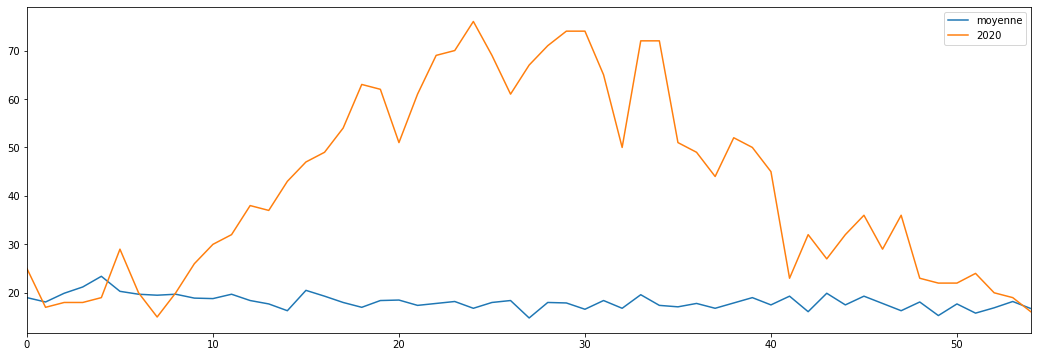

In [31]:
mav20_vs_moyenne_68.plot(figsize=(18, 6))

Une initiative, soufflée par un excellent camarade, consiste à également **calculer [une moyenne glissante](https://fr.wikipedia.org/wiki/Moyenne_mobile) sur les chiffres de 2020**.

Cela permet de comparer deux tendances (certes calculées différemment) mais aussi de lisser des chiffres qui peuvent légèrement varier. Autrement dit, la moyenne glissante du fichier départemental cité avant sera certainement proche de celle calculée ici avec le fichier nominatif.

La [fonction rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) de pandas est taillée pour ça :

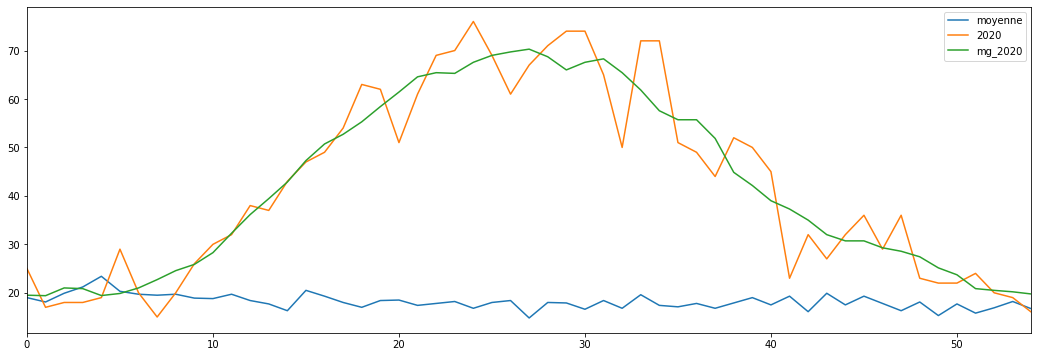

In [32]:
# pour les attributs, on part sur des valeurs calculés sur 7 jours et centrée sur chaque valeur de "2020"
mav20_vs_moyenne_68['mg_2020'] = mav20_vs_moyenne_68['2020'].rolling(7, min_periods=1, center = True).mean()

mav20_vs_moyenne_68.plot(figsize=(18, 6))

Et qu'en est-il pour le Bas-Rhin ? Réponse ici :

In [33]:
# d'abord, on fait la DF de moyenne à partir d'une DF à remplir

moyenne_67 = pd.DataFrame(columns=["d_deces"])
moyenne_67["d_deces"] = mav["d_deces"]

moyenne_67 = moyenne_dep_periode(moyenne_67, 2009, 2019, "03","04","67")

# on sépare le bruit et la moyenne

decennie1019_mav_67 = moyenne_67.drop(columns=['moyenne'])
moyenne_67 = moyenne_67[['d_deces','moyenne']]

# et on passe à 2020

decesq_67_mav20 = panorama_periode_2020("2020-m03", "2020-m04", "03", "04", "67")

decesq_67_mav20.tail()

En  2019 ,  9316  décès survenus dans le département 67 ...
...dont  1692  entre les mois 03  et  04
En  2018 ,  9454  décès survenus dans le département 67 ...
...dont  1777  entre les mois 03  et  04
En  2017 ,  9187  décès survenus dans le département 67 ...
...dont  1541  entre les mois 03  et  04
En  2016 ,  8984  décès survenus dans le département 67 ...
...dont  1545  entre les mois 03  et  04
En  2015 ,  9188  décès survenus dans le département 67 ...
...dont  1615  entre les mois 03  et  04
En  2014 ,  8515  décès survenus dans le département 67 ...
...dont  1499  entre les mois 03  et  04
En  2013 ,  8722  décès survenus dans le département 67 ...
...dont  1622  entre les mois 03  et  04
En  2012 ,  8402  décès survenus dans le département 67 ...
...dont  1476  entre les mois 03  et  04
En  2011 ,  8098  décès survenus dans le département 67 ...
...dont  1418  entre les mois 03  et  04
En  2010 ,  8274  décès survenus dans le département 67 ...
...dont  1411  entre les mois 0

,d_deces,2020
54,24-04,27
55,25-04,17
56,26-04,10
57,27-04,5
58,29-04,1


Là il manque non seulement le 30 avril, mais aussi le 28... On va commencer par harmoniser les deux DF pour les joindre :

In [34]:
decesq_67_mav20 = decesq_67_mav20.iloc[:-1]

mav20_vs_moyenne_67 = moyenne_67.iloc[:-3]

mav20_vs_moyenne_67 = pd.merge(mav20_vs_moyenne_67, decesq_67_mav20, on="d_deces", how='left').fillna(0)

mav20_vs_moyenne_67.tail()

,d_deces,moyenne,2020
53,23-04,26.0,27
54,24-04,25.3,27
55,25-04,24.1,17
56,26-04,23.8,10
57,27-04,27.5,5


Et comme avec le Haut-Rhin, on vire les quelques lignes qui dévient trop de la moyenne, et on calcule ensuite une moyenne glissante sur la colonne de 2020.

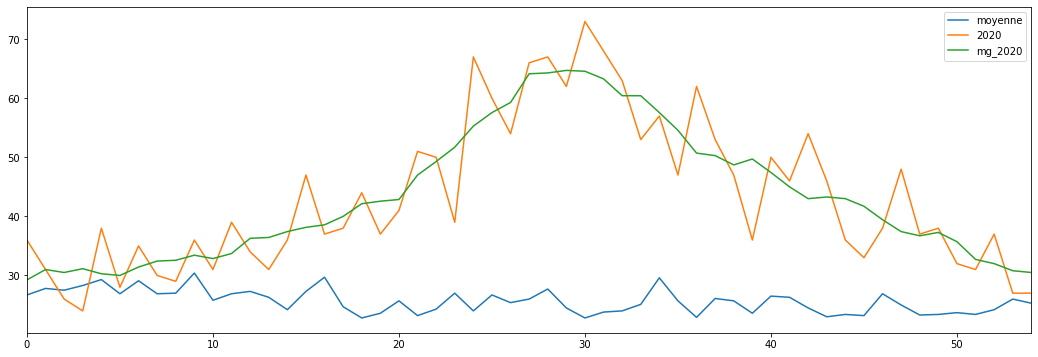

In [35]:
mav20_vs_moyenne_67 = mav20_vs_moyenne_67.iloc[:-3]
mav20_vs_moyenne_67['mg_2020'] = mav20_vs_moyenne_67['2020'].rolling(7, min_periods=1, center = True).mean()

mav20_vs_moyenne_67.plot(figsize=(18, 6))

Cette recette étant efficace (avec quelques réserves sur les vérifications et les dernières dates de 2020), on peut passer au vrai gros morceau.

## Segmentation par âge

Nous allons repartir sur les mêmes bases, mais en ajoutant **une nouvelle information, non négligeable** : l'âge des personnes décédées.

L'objectif est de **segmenter les décès par tranche d'âge**, avec :

* les gens de **65 ans et plus**
* et les autres

Si tout va bien, l'addition de tous ces décès sur un jour devrait correspondre à ce qui a été calculé avant. Cela n'est pas toujours le cas, mais ne brûlons pas les étapes.

Le plus simple est de : 
* calculer **une DF de moyenne** 
* **une DF pour 2020** 
* mais dans lesquelles on ne retient que **les décès survenus certain intervalle d'âge**

On va se pencher sur 2020, et bétonner un maximum avant de coder la fonction déclinée sur la moyenne. Pour l'exemple, on ne retiendra que **les décès de personnes de plus de 90 ans survenus en mars ou en avril 2020**.

Il nous faut (c'est une évidence) une nouvelle DF :

In [36]:
test_65 = fusion_propre("2020-m03","2020-m04")
test_65 = DF_propre(test_65)

57269  lignes dans le premier fichier
70943  lignes dans le second fichier
128212  lignes dans le fichier final


On va perdre le moins de temps possible et coder une fonction qui va calculer (quand c'est possible) l'âge des personnes décédes.

Il faut bien entendu la date de naissance et la date de décès, au bon format pour **que pandas puisse les manipuler**. Le problème est que dans certains cas, **l'INSEE n'avait pas toutes les informations**.

Par exemple, une personne dont la date de naissance est inconnue sera renseignée "00000000" dans le fichier, une dont le mois et le jour sont inconnus sera notée "19390000", etc. Ce qui fera planter pandas.

Pour éviter cela, la future fonction **va masquer les valeurs aberrantes**, pour qu'on puisse les convertir sans risquer le plantage. Cela donne :

In [37]:
def calcul_age(tampon):
    # la colonne 'deces' étant rempli de NaN, on copie 'd_deces' à la place
    tampon['deces'] = tampon['d_deces']
    
    # ensuite, un premier masque sur ces décès, avec les tranchages qui vont bien
    masque_deces = ((tampon["deces"].str[:4] != "0000") & (tampon["deces"].str[4:6] != "00") & (tampon["deces"].str[6:8] != "00"))
    # et on applique le masque
    tampon = tampon.loc[masque_deces]
    
    # même chose avec les naissances
    masque_naissance = ((tampon["naissance"].str[:4] != "0000") & (tampon["naissance"].str[4:6] != "00") & (tampon["naissance"].str[6:8] != "00"))
    tampon = tampon.loc[masque_naissance]
    
    # on convertit en date chacun des colonnes
    tampon["naissance"] = pd.to_datetime(tampon["naissance"])
    tampon["deces"] = pd.to_datetime(tampon["deces"])
    
    # et on met à jour la colonne 'age'
    tampon["age"] = ((tampon["deces"] - tampon["naissance"])/365).dt.days
    
    print("Soit ",len(tampon["naissance"]), " décès dont l'âge est calculable")
    
    #plus qu'à servir
    return tampon

Si on a fait les choses bien, test_65 devrait se remplir sans NaN. Hopla, c'est parti :

In [38]:
test_65 = calcul_age(test_65)

Soit  126955  décès dont l'âge est calculable


Pas loin de 2 000 décès retranchés, ça par exemple ! Et côté nouvelles colonnes...

In [39]:
test_65.tail()

,naissance,deces,age,dep_deces,d_deces,n_acte_deces
128207,1973-02-26,2020-01-18,46.0,99,20200118,986
128208,1942-05-29,2020-01-23,77.0,99,20200123,987
128209,1927-07-16,2020-01-16,92.0,99,20200116,988
128210,1956-06-25,2019-12-12,63.0,99,20191212,989
128211,1941-11-23,2019-10-01,77.0,99,20191001,990


Ça a l'air pas mal du tout, **en tout cas les calculs d'âge sont corrects**. 

On va retailler dans le vif en ne retenant que les décès survenus en 2020, dans le Haut-Rhin, en mars ou en avril. Ce refrain est maintenant connu :

In [40]:
test_65 = annee_stricte(test_65, "2020")
test_65 = selection_dep(test_65, "68")
test_65 = bimensuel(test_65, "03","04")

test_65.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2334 entries, 36405 to 99143
Data columns (total 6 columns):
naissance       2334 non-null datetime64[ns]
deces           2334 non-null datetime64[ns]
age             2334 non-null float64
dep_deces       2334 non-null object
d_deces         2334 non-null object
n_acte_deces    2334 non-null object
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 127.6+ KB


En comparaison d'avant, on a 13 décès retranchés (donc 13 personnes dont l'âge n'était pas calculable). 

Les observateurs auront aussi remarqué que l'âge s'affiche **comme un nombre à décimales**. La moindre des choses est de le convertir en entiers. Ca se fait très simplement avec pandas :

In [41]:
test_65['age'] = test_65['age'].astype(int)

Wunderbar ! A présent, il est temps de sélectionner les décès survenus à 80 ans ou plus. Au moins deux solutions (donc deux fonctions) sont envisageables :

* définir un âge de début et un âge de fin d'intervalle **et faire un double test** (est retenu le décès dont l'âge est supérieur au début et inférieur à la fin
* définir **un intervalle à la catalane** ("nous, et les autres") avec la fonction [pandas cut()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) et en expurgeant tout ce qui est autre

Deux variables, deux fonctions, c'est parti :

In [42]:
test_65_dtest = test_65
test_65_intervalle = test_65

# d'abord la fonction double test

def selection_age_test(DF, age_d, age_f):
    masque_age = ((DF["age"] > age_d) & (DF["age"] < age_f))
    DF = DF.loc[masque_age]
    return DF

# ensuite, celle d'intervalle

def selection_age_intervalle(DF, age_d, age_f):
    if age_f == 120:
        DF["intervalle"] = pd.cut(DF['age'], bins=[0,age_d,age_f], labels=["les autres", "80 et plus"])
    else:
        DF["intervalle"] = pd.cut(DF['age'], bins=[age_d,age_f,120], labels=[age_f, "les autres"])
    
    DF = DF[DF["intervalle"] != "les autres"]
    return DF

# on teste chaque fonction avec sa variable

test_65_dtest = selection_age_test(test_65_dtest, 64, 120)
test_65_intervalle = selection_age_intervalle(test_65_intervalle, 64, 120)

test_65_dtest.info()
test_65_intervalle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 36405 to 99143
Data columns (total 6 columns):
naissance       2127 non-null datetime64[ns]
deces           2127 non-null datetime64[ns]
age             2127 non-null int64
dep_deces       2127 non-null object
d_deces         2127 non-null object
n_acte_deces    2127 non-null object
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 116.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 36405 to 99143
Data columns (total 7 columns):
naissance       2127 non-null datetime64[ns]
deces           2127 non-null datetime64[ns]
age             2127 non-null int64
dep_deces       2127 non-null object
d_deces         2127 non-null object
n_acte_deces    2127 non-null object
intervalle      2127 non-null category
dtypes: category(1), datetime64[ns](2), int64(1), object(3)
memory usage: 118.5+ KB


Deux DF aux mêmes nombres de lignes, a priori semblables si on enlève la nouvelle colonne "intervalle" dans la deuxième. On va pousser la vice jusqu'à vérifier les valeurs uniques de la colonne "age", dans chacune d'entre elles :

In [43]:
print(test_65_dtest["age"].unique())
print(test_65_intervalle["age"].unique())

[ 80  90  70  92  85  78  94  74  79  75  77  84  82 102  87  89  81  86
  83  88  93  95  71  97  91 103  99  76  69  72  73  68  67  66  65  98
  96 101 100 106 105]
[ 80  90  70  92  85  78  94  74  79  75  77  84  82 102  87  89  81  86
  83  88  93  95  71  97  91 103  99  76  69  72  73  68  67  66  65  98
  96 101 100 106 105]


Tout a l'air bien ! Pour cette fois on va préférer test_80_dtest qu'on va expurger des Series 'naissance', 'deces', et 'age' :

In [44]:
test_65 = test_65_dtest[['d_deces','n_acte_deces']]

On peut à présent revenir à l'étape de regroupement/tri par date, avec la fonction compteur_quotidien :

In [45]:
test_65 = compteur_quotidien(test_65, "2020")

test_65.head()

<ipython-input-15-80f17c0d05a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF["d_deces"] = DF["d_deces"].str.replace(r'\d{4}(\d{2})(\d{2})', r'\g<1>-\g<2>')


,d_deces,2020
0,01-03,24
1,02-03,16
2,03-03,16
3,04-03,16
4,05-03,17


Peut on résumer ceci en une fonction ? Bien entendu !

In [46]:
def panoramage_2020(fichier1, fichier2,m_debut,m_fin,age_d, age_f,dpt):
    annee = "2020"
    DF = fusion_propre(fichier1, fichier2)
    DF = DF_propre(DF)
    
    DF = annee_stricte(DF, annee)
    DF = selection_dep(DF, dpt)
    DF = bimensuel(DF, m_debut,m_fin)
    
    # on place calcul_age() vers la fin du script, car la fonction fait planter le script si on la déclare avant
    DF = calcul_age(DF)
    DF = selection_age_test(DF, age_d, age_f)
    
    DF = compteur_quotidien(DF, annee)
    
    return DF

On peut vérifier l'intégrité de la fonction par un test :

In [47]:
deces_68_65_mav2020 = panoramage_2020("2020-m03","2020-m04","03","04",64,120,"68")

deces_68_65_mav2020.head()

57269  lignes dans le premier fichier
70943  lignes dans le second fichier
128212  lignes dans le fichier final
Soit  2334  décès dont l'âge est calculable


,d_deces,2020
0,01-03,24
1,02-03,16
2,03-03,16
3,04-03,16
4,05-03,17


Tout colle, parfait !

Comme la formule est maintenant à peu près rodée, on part sur fonction qui calcule une moyenne d'une période donnée :

In [48]:
def moyenne_dep_age_periode(DF_a_remplir, a_debut, a_fin, m_debut, m_fin, age_d, age_f, dpt):
    periode = [str(an) for an in range(a_fin, a_debut, -1)]
    
    for annee in periode:
        #print("En ", annee, " :")
        DF = ouverture_facile(annee)
        DF = DF_propre(DF)
    
        #print(len(DF["d_deces"]), "décès")
        DF = annee_stricte(DF, annee)
        
        #print("dont ",len(DF["d_deces"]), "survenus uniquement cette année")
        DF = selection_dep(DF, dpt)
        DF = bimensuel(DF, m_debut,m_fin)
        print("Dans le département",dpt,", ", len(DF["d_deces"]), " décès entre ",m_debut, " et ", m_fin," ", annee)
        
        DF = calcul_age(DF)
        #print("Et ", len(DF["d_deces"]), " personnes dont l'âge est calculable")
        
        DF = selection_age_test(DF, age_d, age_f)
        print("Et ", len(DF["d_deces"]), "décès de personnage âgées entre", DF["age"].unique())
    
        DF = compteur_quotidien(DF, annee)
        DF[annee] = DF[annee].astype(int)
        
        # le fillna(0) est d'autant plus important qu'il y a des jours où on a effectivement aucun décès
        DF_a_remplir = pd.merge(DF_a_remplir, DF, on="d_deces", how='left').fillna(0)


    DF_a_remplir["moyenne"] = DF_a_remplir[periode].mean(axis=1)
    return DF_a_remplir

Et on déroule sur la tranche 65 ans et plus dans le Haut-Rhin :

In [49]:
moyenne_68_mav_65 = pd.DataFrame(columns=["d_deces"])
moyenne_68_mav_65["d_deces"] = mav["d_deces"]

moyenne_68_mav_65 = moyenne_dep_age_periode(moyenne_68_mav_65, 2009, 2019, "03", "04", 64, 120, "68")

Dans le département 68 ,  1163  décès entre  03  et  04   2019
Soit  1159  décès dont l'âge est calculable
Et  989 décès de personnage âgées entre [ 82  66  85  86  84  83  87  98  99  74  89  65  94  92  67  69  88  90
  91  70  93  77  78  97  80  68  73  75  71  72  76  95  79  81  96 102
 104 101 105 100 103]
Dans le département 68 ,  1243  décès entre  03  et  04   2018
Soit  1237  décès dont l'âge est calculable
Et  1075 décès de personnage âgées entre [ 84  73  87  96  89  82  79  90  97  81  91  74  83  76  94  98  88  95
  85 100  86  80  69  93  75  92  70  78  99  66  68  65  71  77  72  67
 101 103 107 110 102 105 104]
Dans le département 68 ,  1056  décès entre  03  et  04   2017
Soit  1053  décès dont l'âge est calculable
Et  885 décès de personnage âgées entre [ 97  70  86  94  84  85  82  87  89  91  92  80  93  90  69  79  73  83
  71  68  75 100  74  66  78  67  65  77  96  88  81  72  98  95  99  76
 103 104 102]
Dans le département 68 ,  1095  décès entre  03  et  0

Zieutons la tête de notre DF :

In [50]:
moyenne_68_mav_65

,d_deces,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,moyenne
0,01-03,17,22,14,14,23,12,19,21,8,11,16.1
1,02-03,19,15,11,14,15,10,18,21,11,17,15.1
2,03-03,10,20,14,16,20,20,14,23,16,21,17.4
3,04-03,21,29,17,20,12,9,21,16,15,14,17.4
4,05-03,17,25,19,18,28,17,24,18,25,11,20.2
...,...,...,...,...,...,...,...,...,...,...,...,...
56,26-04,23,13,18,15,10,10,10,18,10,13,14.0
57,27-04,19,17,12,16,12,16,8,12,12,14,13.8
58,28-04,21,10,20,20,17,13,11,15,12,11,15.0
59,29-04,15,17,17,10,16,12,13,14,8,12,13.4


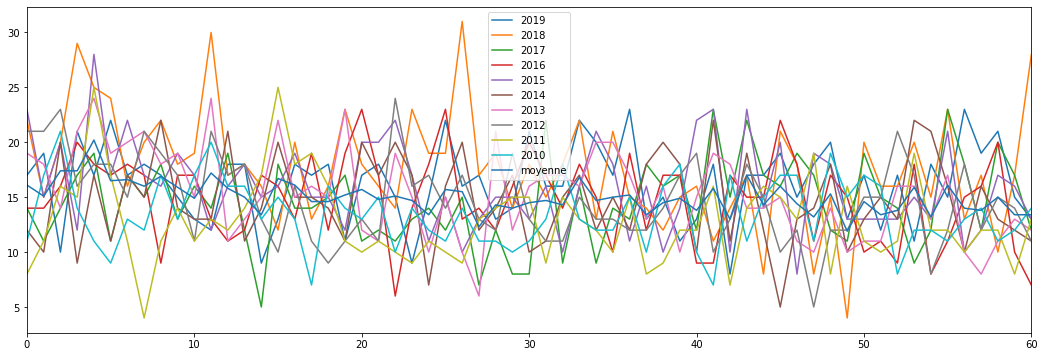

In [51]:
moyenne_68_mav_65.plot(figsize=(18, 6))

Comme avant, on ne retient que le bruit et on met la moyenne de côté :

In [52]:
decennie1019_68_65 = moyenne_68_mav_65.drop(columns=['moyenne'])
moyenne_68_mav_65 = moyenne_68_mav_65[['d_deces','moyenne']]

# et on fusionne tout ça avec les données de 2020
m1019_vs_mav20_65_68 = pd.merge(moyenne_68_mav_65, deces_68_65_mav2020, on="d_deces", how='left').fillna(0)

m1019_vs_mav20_65_68.tail()

,d_deces,moyenne,2020
56,26-04,14.0,5.0
57,27-04,13.8,10.0
58,28-04,15.0,3.0
59,29-04,13.4,1.0
60,30-04,13.4,0.0


Plus qu'à rassembler tout ça :

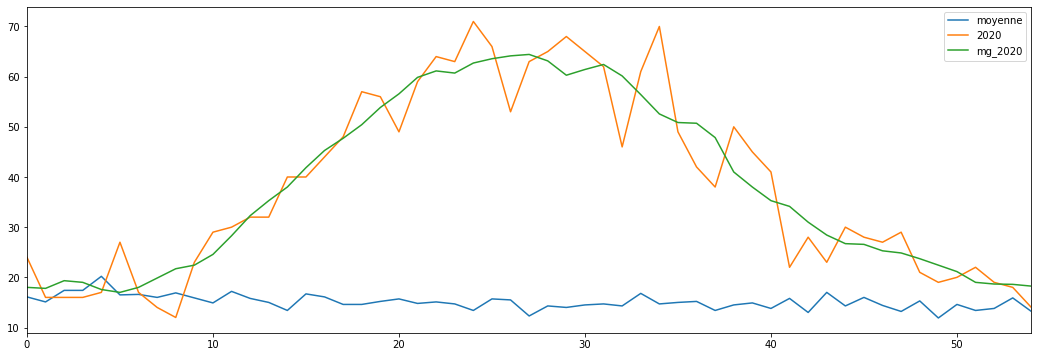

In [53]:
m1019_vs_mav20_65_68 = m1019_vs_mav20_65_68.iloc[:-6]
m1019_vs_mav20_65_68['mg_2020'] = m1019_vs_mav20_65_68['2020'].rolling(7, min_periods=1, center = True).mean()

m1019_vs_mav20_65_68.plot(figsize=(18,6))

De là on peut faire la même chose pour le Bas-Rhin, varier les périodes, les âges, les départements... Tout un programme, **qu'on ne détaillera pas ici**.

Il reste (malgré cela) une toute dernière chose à aborder.

## La création de json propres

Il est temps à présent de créer des json, qui serviront à des visualisations codées avec **la bibliothèque JavaScript D3**.

Pour ça, deux objets ("Bas-Rhin" et "Haut-Rhin") remplis de données. **L'objet JS ayant la même structure que le dictionnaire Python**, nous sommes bien partis.

On commence par fusionner nos entités côté Haut-Rhin :

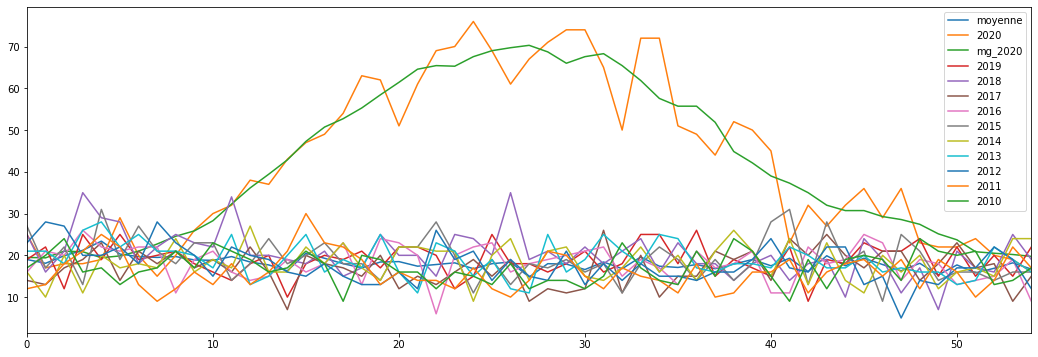

In [54]:
transit68 = pd.merge(mav20_vs_moyenne_68, bruit_mav_68, on="d_deces", how='left').fillna(0)

transit68.plot(figsize=(18, 6))

Puis on passe à la conversion au dictionnaire, grâce à [la fonction pandas to_dict()] :

In [55]:
dict_68 = transit68.to_dict('records')

Même chose pour le Bas-Rhin :

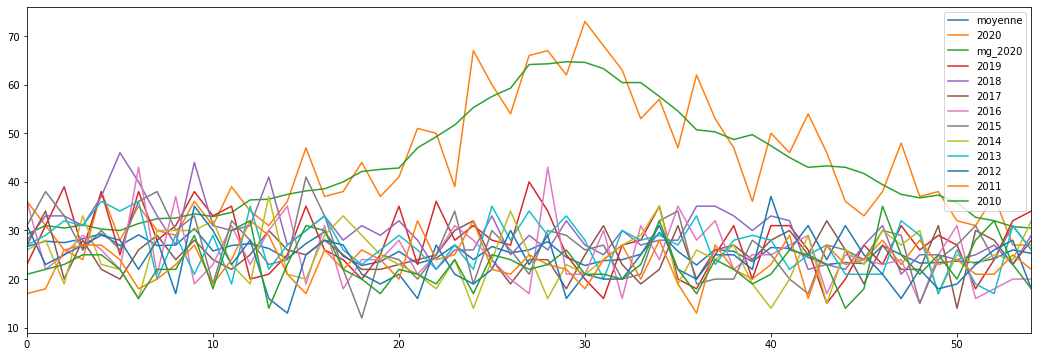

In [56]:
transit67 = pd.merge(mav20_vs_moyenne_67, decennie1019_mav_67, on="d_deces", how='left').fillna(0)

transit67.plot(figsize=(18, 6))

In [57]:
dict_67 = transit67.to_dict('records')

On part sur un dico global, qui va contenir les deux précédents dictionnaires :

In [58]:
dico_transit = {"Bas-Rhin": dict_67, "Haut-Rhin": dict_68}

Et on le convertit en json grâce au modèle dédié :

In [59]:
import json

with open('data.json', 'w') as fp:
    json.dump(dico_transit, fp)

On ne va tout de même pas se quitter avant **d'avoir codé une dernière fonction**, en pensant aux éventuels confrères qui n'ont pas la chance d'avoir deux départements ! Elle aura en arguments :

* une liste de chaînes de caractères ("Moselle", "Ariège", que sais-je !)
* une liste de DF "miroir" (celle de Moselle au même index que la chaîne de caractères précédentes, etc)
* un nom de fichier

Ce qui donne :

In [60]:
def DF_en_json(l_dep, l_DF, nfichier):
    dico_global = {dep: DF.to_dict('records') for dep, DF in zip(l_dep, l_DF)}
    with open(nfichier, 'w') as fp:
        json.dump(dico_global, fp)